# NLP Exercise 6: Magic The Gathering Cards

In this exercise, we will file-tuned a transformer language model to create our own [Magic: The Gathering](https://en.wikipedia.org/wiki/Magic:_The_Gathering) (MTG) trading cards.

MTG is a card game with special cards based on fantasy themes, like the following:

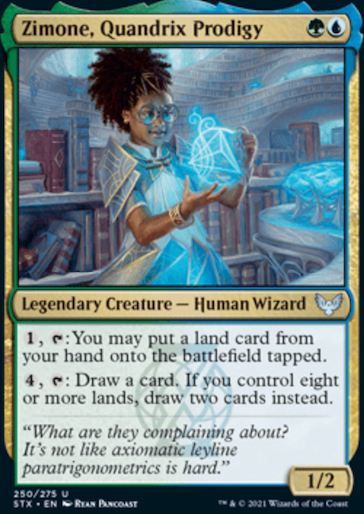

We will fine-tune a neural network to **generate our own MTG trading cards** with the same style of text. In particular, we will focus on the following four textual elements on cards:
* **Name**: At the top of the card (above: *Zimone, Quandrix Prodigy*)
* **Type:** The line underneath the card's art (above: *Legendary Creature - Human Wizard*)
* **Text:** The central text describing how the card is used in the game (above: the text with special symbols in the center of the card)
* **Flavor text:** Text at the bottom of a card giving some plot information or personality to the card (above: *What are they complaining about? It's not like axiomatic leyline paratrigonometrics is hard.*)

We will learn to generate these fields using data from the [MTGJSON](https://mtgjson.com/) project, which collects structured data about all MTG cards that have been published since the game was launched in 1993.

# Part 1: Setup

**Questions:**

1. Make sure the following HuggingFace Python libraries are installed: `transformers`, `datasets`.

In [1]:
! pip install transformers
! pip install datasets

2. Download the MTGJSON card dataset from the following link, and decompress the compressed archive (recommended to use `wget` and `tar xzfv`): https://mtgjson.com/api/v5/AllPrintingsCSVFiles.tar.gz

In [2]:
! wget https://mtgjson.com/api/v5/AllPrintingsCSVFiles.tar.gz

--2024-03-27 14:16:57--  https://mtgjson.com/api/v5/AllPrintingsCSVFiles.tar.gz
Resolving mtgjson.com (mtgjson.com)... 188.114.97.0, 188.114.96.0, 2a06:98c1:3121::, ...
Connecting to mtgjson.com (mtgjson.com)|188.114.97.0|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 90622869 (86M) [application/octet-stream]
Saving to: ‘AllPrintingsCSVFiles.tar.gz.2’

AllPrintingsCSVFile 100%[===================>]  86.42M   141MB/s    in 0.6s    

2024-03-27 14:16:57 (141 MB/s) - ‘AllPrintingsCSVFiles.tar.gz.2’ saved [90622869/90622869]



In [3]:
! tar xzfv AllPrintingsCSVFiles.tar.gz

AllPrintingsCSVFiles/
AllPrintingsCSVFiles/cardPurchaseUrls.csv
AllPrintingsCSVFiles/cardRulings.csv
AllPrintingsCSVFiles/setTranslations.csv
AllPrintingsCSVFiles/cardForeignData.csv
AllPrintingsCSVFiles/cards.csv
AllPrintingsCSVFiles/cardPrices.csv
AllPrintingsCSVFiles/setBoosterSheets.csv
AllPrintingsCSVFiles/tokens.csv
AllPrintingsCSVFiles/tokenIdentifiers.csv
AllPrintingsCSVFiles/meta.csv
AllPrintingsCSVFiles/setBoosterContents.csv
AllPrintingsCSVFiles/setBoosterContentWeights.csv
AllPrintingsCSVFiles/cardLegalities.csv
AllPrintingsCSVFiles/cardIdentifiers.csv
AllPrintingsCSVFiles/setBoosterSheetCards.csv
AllPrintingsCSVFiles/sets.csv


3. Load the data in `cards.csv` into a Pandas DataFrame `df`. Use `usecols=` to include only the following columns: `name`, `type`, `text`, `flavorText`. Drop duplicate rows and rows with missing values, and display some sample rows. How many samples remain in the dataset? (should be a number between 15k-20k)

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('AllPrintingsCSVFiles/cards.csv', usecols = ['name','type','text','flavorText'])

In [5]:
df.dropna(inplace = True)

In [6]:
df.drop_duplicates(inplace = True)

In [7]:
df.shape

(22225, 4)

There is 22,225 samples left.

4. Plot separate histograms of the lengths of each of the four textual fields, measured by number of words. What can you say about their distributions? Hint: `pd.Series.str.split().str.len()`

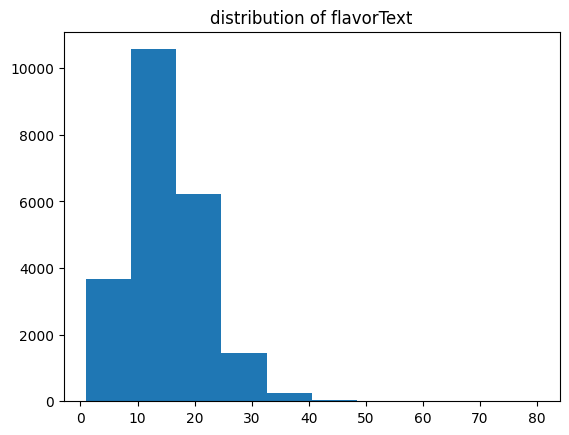

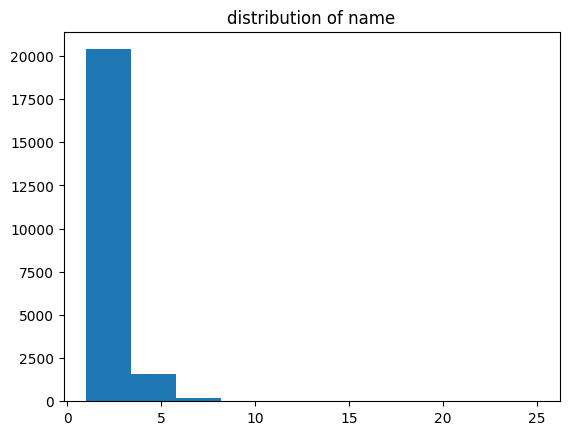

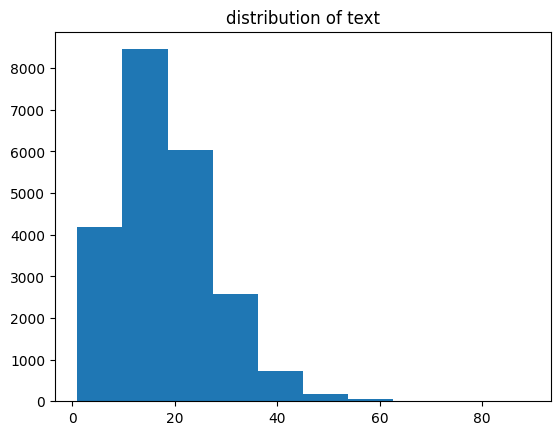

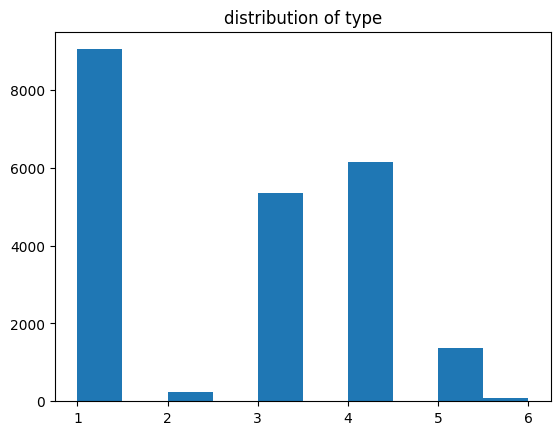

In [8]:
import matplotlib.pyplot as plt
for col in df.columns:
  plt.hist(df[col].str.split().str.len())
  plt.title(f'distribution of {col}')
  plt.show()

We see that values on the features have more or less the same number of words.

5. Print out the contents of at least one card whose `text` field is short and one card whose text field is long.

In [9]:
df[df.text.str.split().str.len() < 5].sample()

,flavorText,name,text,type
27160,"""I wrote these tales with a quill made from a ...",Prized Griffin,Flying,Creature — Griffin


In [10]:
df[df.text.str.split().str.len() > 60].sample()

,flavorText,name,text,type
32313,"""We could feel the Shaman's power, as surely a...",Illusionary Presence,Cumulative upkeep {U} (At the beginning of you...,Creature — Illusion


# Part 2: Preprocessing

**Questions:**
6. It will be easier to manage generating one piece of text instead of four, so we will combine all four fields into a single string. Add a new column `card_data` to the DataFrame combining all four fields together as follows:
  * `"NAME: "` followed by the card's name and newline `\n`
  * `"TYPE: "` followed by the card's type and newline `\n`
  * `"TEXT: "` followed by the card's main text and newline `\n`
  * `"FLAVOR: "` followed by the card's flavor text and newline `\n`

  Combine these together into one string by joining them together with newlines. For example, the card *Knotvine Mystic* will have the following multi-line string as its `card_data`:

`NAME: Knotvine Mystic`

`TYPE: Creature — Elf Druid`

`TEXT: {1}, {T}: Add {R}{G}{W}.`

`FLAVOR: The elves of Naya were the last to acknowledge the massive shift of mana in their world.`

In [11]:
df['card_data'] = 'NAME: ' + df['name'] + '\n' + \
                  'TYPE: ' + df['type'] + '\n' + \
                  'TEXT: ' + df['text'] + '\n' + \
                  'FLAVOR: ' + df['flavorText'] + '\n'

7. Print out the `card_data` for a few cards.

In [12]:
print(df.card_data.iloc[0])

NAME: Ancestor's Chosen
TYPE: Creature — Human Cleric
TEXT: First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard.
FLAVOR: "The will of all, by my hand done."



In [13]:
print(df.card_data.iloc[1])

NAME: Angel of Mercy
TYPE: Creature — Angel
TEXT: Flying\nWhen Angel of Mercy enters the battlefield, you gain 3 life.
FLAVOR: Every tear shed is a drop of immortality.



8. We will need a tokenizer to continue preprocessing. Load the tokenizer for `distilgpt2` (a small GPT-2 variant) using `transformers.AutoTokenizer`.

In [14]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('distilgpt2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


9. Check out the tokenizer vocabulary.
- Explain what do you see in  `tokenizer.vocab` and `tokenizer.vocab_size`.
- What is the min, max, mean and median length of a token text?  
- Print out some of the shortest, median and longest tokens

In [15]:
tokenizer.vocab

{'Ġunthinkable': 39593,
 'Ġà¤': 28225,
 'Ġsubs': 6352,
 'ĭ': 233,
 'ĠNich': 12760,
 'ĠJail': 25715,
 'ĠLac': 23115,
 'inous': 29823,
 'ĠKT': 42293,
 'sem': 43616,
 'payers': 45773,
 'Ġdots': 22969,
 'Spl': 26568,
 'ĠAdvent': 33732,
 'Ġ95': 6957,
 'irty': 5893,
 '================================================================': 23926,
 'ĠThousand': 39255,
 'ĠCreed': 24299,
 'ĠGIF': 24984,
 'ĠDPRK': 48363,
 'rency': 5227,
 'ĠHank': 24386,
 'Ġexcept': 2845,
 'Ġuseful': 4465,
 'Ġrejects': 28317,
 'ĠCollege': 5535,
 'Ġprov': 899,
 'boats': 46058,
 'Ġalpha': 17130,
 'Ġcharism': 25348,
 'world': 6894,
 'everal': 8438,
 'Ġinventor': 33475,
 'æ°': 36365,
 'Ġsauces': 50134,
 'Ġpand': 19798,
 'ĠLakers': 19616,
 'liga': 38910,
 'oses': 4629,
 'ĠBows': 31417,
 'Ġlesions': 35258,
 'Ġislands': 14807,
 'struct': 7249,
 'remlin': 17244,
 'Ġhardware': 6890,
 'dragon': 14844,
 'Ġsheets': 15747,
 'ihil': 20898,
 'ĠForce': 5221,
 'Ġrejected': 8606,
 'ĠVehicles': 31365,
 'Ġlinger': 31402,
 'ĠVander': 26669

We have each words and its given id.

In [16]:
tokenizer.vocab_size

50257

This is the number of words on the tokenizer.

In [17]:
min(len(key) for key in tokenizer.vocab.keys())

1

The minimal length is 1

In [18]:
max(len(key) for key in tokenizer.vocab.keys())

128

The maximum length is 128

In [19]:
np.mean([len(key) for key in tokenizer.vocab.keys()])

6.383727639930756

The mean length is 6.3

In [20]:
np.median([len(key) for key in tokenizer.vocab.keys()])

6.0

The median length is 6

In [21]:
sorted_keys = sorted(tokenizer.vocab.keys(), key=len)

In [22]:
print(f' Word with a min length : {sorted_keys[0]}')

 Word with a min length : ĭ


In [23]:
print(f' Word with a max length : {sorted_keys[::-1][0]}')

 Word with a max length : ÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤÃĥÃĤ


In [24]:
print(f'Word with a median length : {sorted_keys[np.where([len(word)==6 for word in sorted_keys])[0][0]]}')

Word with a median length : payers


10. Our tokenizer has one "special token" which is used to indicate the end of text. View it with `tokenizer.all_special_tokens`. We also need to use "padding token" (see next questions) that is not set by default. Run the code provided below and verify that it is now listed as the padding token in `tokenizer.special_tokens_map`.

  **Advanced note:** A HF Transformers tokenizer may have BOS (beginning of string), EOS (end of string), padding, and UNK (unknown) special tokens; `special_tokens_map` lists them if they are set.

In [25]:
# CODE FOR QUESTION 10
tokenizer.pad_token = tokenizer.eos_token

In [26]:
tokenizer.all_special_tokens

['<|endoftext|>']

11. Explain the difference in the output of each line of code below. What is "padding"?

In [27]:
# CODE FOR QUESTION 11
sentences1 = ['This is a sentence.', 'This too.']
print(tokenizer(sentences1))
print(tokenizer(sentences1, padding=True))

{'input_ids': [[1212, 318, 257, 6827, 13], [1212, 1165, 13]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1]]}
{'input_ids': [[1212, 318, 257, 6827, 13], [1212, 1165, 13, 50256, 50256]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]]}


Padding adds 0 at the end of each input in order to have each input at the same size.

12. Explain the difference in the output of each line of code below. What is "truncation"?

In [28]:
# CODE FOR QUESTION 12
sentences2 = ['This is a sentence.', 'This too.', 'And this is a very, very, very, very long sentence.']
print(tokenizer(sentences2))
print(tokenizer(sentences2, truncation=True, max_length=5))

{'input_ids': [[1212, 318, 257, 6827, 13], [1212, 1165, 13], [1870, 428, 318, 257, 845, 11, 845, 11, 845, 11, 845, 890, 6827, 13]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}
{'input_ids': [[1212, 318, 257, 6827, 13], [1212, 1165, 13], [1870, 428, 318, 257, 845]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1], [1, 1, 1, 1, 1]]}


Truncation with a max_length = 5 means that we keep only the first 5 words of each input. We then truncate input with more than 5 words.

13. Explain the difference in the output of each line of code below.

In [29]:
# CODE FOR QUESTION 13
print(tokenizer(sentences1, padding=True, truncation=True, max_length=10))
print(tokenizer(sentences1, padding='max_length', truncation=True, max_length=10))

{'input_ids': [[1212, 318, 257, 6827, 13], [1212, 1165, 13, 50256, 50256]], 'attention_mask': [[1, 1, 1, 1, 1], [1, 1, 1, 0, 0]]}
{'input_ids': [[1212, 318, 257, 6827, 13, 50256, 50256, 50256, 50256, 50256], [1212, 1165, 13, 50256, 50256, 50256, 50256, 50256, 50256, 50256]], 'attention_mask': [[1, 1, 1, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]]}


It adds 0 to inputs with a length lower than 10 and truncate inputs with a length higher than 10.

14. We will use HuggingFace's `datasets.Dataset` object to store our training data. In general makes it easier to apply memory-efficient transformations to data, combine data into minibatches, shuffle data before training, and even to load data on the fly without needing to store everything in memory at once.

  Create a `datasets.Dataset` object using `Dataset.from_pandas(...)` and store the output in a variable `ds`.

In [30]:
from datasets import Dataset
ds = Dataset.from_pandas(df)

15. Examine the dataset by printing out `ds`, `len(ds)` and `ds.num_rows` (same output), `ds.info`, and `ds[0]`.

In [31]:
print(ds)

Dataset({
    features: ['flavorText', 'name', 'text', 'type', 'card_data', '__index_level_0__'],
    num_rows: 22225
})


In [32]:
len(ds)

22225

In [33]:
ds.num_rows

22225

In [34]:
ds.info

DatasetInfo(description='', citation='', homepage='', license='', features={'flavorText': Value(dtype='string', id=None), 'name': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None), 'type': Value(dtype='string', id=None), 'card_data': Value(dtype='string', id=None), '__index_level_0__': Value(dtype='int64', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name=None, dataset_name=None, config_name=None, version=None, splits=None, download_checksums=None, download_size=None, post_processing_size=None, dataset_size=None, size_in_bytes=None)

In [35]:
ds[0]

{'flavorText': '"The will of all, by my hand done."',
 'name': "Ancestor's Chosen",
 'text': "First strike (This creature deals combat damage before creatures without first strike.)\\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard.",
 'type': 'Creature — Human Cleric',
 'card_data': 'NAME: Ancestor\'s Chosen\nTYPE: Creature — Human Cleric\nTEXT: First strike (This creature deals combat damage before creatures without first strike.)\\nWhen Ancestor\'s Chosen enters the battlefield, you gain 1 life for each card in your graveyard.\nFLAVOR: "The will of all, by my hand done."\n',
 '__index_level_0__': 1}

16. Now let's tokenize our data efficiently. Using `ds_encoded = ds.map(lambda row: ...)`, apply tokenization to the `card_data` field of each row. Instructions:
  * In the lambda function, `row['card_data']` gets the card data for a row. Apply tokenization to it.
  * Use the `max_length`, `padding`, and `truncation` arguments to the tokenizer so that every output is **exactly 128 tokens long**. (You don't need to check, but this is enough not to truncate vast majority of the training data)
  * Use `batched=True` in `map(..)` so that many texts are tokenized at once. Try running with and without this argument to verify that it is significantly faster.
  * Use the `remove_cols=` argument in `map(...)` so that the encoded dataset only has features `input_ids` and `attention_mask`. This is desirable because we don't need to waste memory by storing a copy of all the other text fields which we are no longer using.

In [36]:
ds_encoded = ds.map(lambda row : tokenizer(row['card_data'],max_length = 128, padding = 'max_length', truncation = True), batched = True,remove_columns = ds.column_names)

Map:   0%|          | 0/22225 [00:00<?, ? examples/s]

17. Run the following line of code to add a new feature `'labels'` to the dataset, which contains a copy of `'input_ids'`. These are used as the target labels in teacher forcing training. Print out `ds_encoded` and verify that it now contains a new feature `'labels'`.

  **Advanced note:** The HF Transformers `TFAutoModelForCausalLM` API understands that the targets should be shifted over by one during training (i.e. on input of words 1,2,3 it must predict word 4); you don't need to shift them yourself.

In [37]:
# CODE FOR QUESTION 17
ds_encoded = ds_encoded.map(lambda examples: {'labels': examples['input_ids']})

Map:   0%|          | 0/22225 [00:00<?, ? examples/s]

In [38]:
ds_encoded

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 22225
})

18. Use `.with_format('tf')` to convert the dataset contents to TF tensors, and verify that the contents were modified with `ds_encoded[0]`.

In [39]:
ds_encoded = ds_encoded.with_format('tensorflow')

In [40]:
ds_encoded[0]

{'input_ids': <tf.Tensor: shape=(128,), dtype=int64, numpy=
 array([20608,    25, 31200,   273,   338, 39884,   198, 25216,    25,
        33248,   851,  5524,  1012, 35626,   198, 32541,    25,  3274,
         5587,   357,  1212,  7185,  7529,  5249,  2465,   878,  8109,
         1231,   717,  5587,  2014,    59,    77,  2215, 31200,   273,
          338, 39884, 14170,   262, 13480,    11,   345,  4461,   352,
         1204,   329,  1123,  2657,   287,   534, 27672,    13,   198,
         3697, 10116,  1581,    25,   366,   464,   481,   286,   477,
           11,   416,   616,  1021,  1760,   526,   198, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50

19. Use `tokenizer.decode(...)` with `ds_encoded[0]['input_ids']` to view the contents of the first sample. Verify that the output makes sense. Try running this with and without the argument `skip_special_tokens=True`; what is the difference in output?

In [41]:
tokenizer.decode(ds_encoded[0]['input_ids'], skip_special_tokens=True)

'NAME: Ancestor\'s Chosen\nTYPE: Creature — Human Cleric\nTEXT: First strike (This creature deals combat damage before creatures without first strike.)\\nWhen Ancestor\'s Chosen enters the battlefield, you gain 1 life for each card in your graveyard.\nFLAVOR: "The will of all, by my hand done."\n'

With skip_special_tokens=True we do not have the special token of end of text.

20. Run the code provided below to create a TensorFlow Dataset object with the given data shuffled (random order) and split into minibatches of size 4. Then try running `X = next(iter(tf_ds))` to retrieve a single minibatch, and explain the contents of `X`.

**Note:** You can run `len(tf_ds)` to count the total number of minibatches in the dataset. The batch size might not divide the total number of samples; if this occurs, then by default there will be one smaller minibatch.

In [42]:
# CODE FOR QUESTION 20
tf_ds = ds_encoded.to_tf_dataset(
    batch_size=4,
    shuffle=True
)

In [43]:
X = next(iter(tf_ds))


In [44]:
len(tf_ds)

5557

In [45]:
X

{'input_ids': <tf.Tensor: shape=(4, 128), dtype=int64, numpy=
 array([[20608,    25, 42271, 31203, 15799,   198, 25216,    25, 33248,
           851, 43966,  6286, 16432,   198, 32541,    25,  1391,    16,
          5512, 42036,   281, 24127,    25,  5930,   257,  1343,    16,
         28404,    16,  3753,   319, 42271, 31203, 15799,    13,   632,
          8810,   773,   395,  1356,   856,  1566,   886,   286,  1210,
            13,   198,  3697, 10116,  1581,    25,   366,   464,  2756,
          2125,   470,  2469,   313,  3379,    11,   475,   314,  1101,
          1654,   345,  1183,  4236,   340,   338,  3148,   526,   198,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
  

X is the first element of tf_ds. If we do next(...) again, we get the second element

# Part 3: Training the Model

**Questions:**

21. Using `transformers.TFAutoModelForCausalLM`, load the pretrained `'distilgpt2'` model with a language modeling head in a variable `model`.

In [46]:
import transformers
model = transformers.TFAutoModelForCausalLM.from_pretrained('distilgpt2')

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


22. Using `output = model.predict(X)`, look at the (currently not fine-tuned) network's results on a single minibatch of data. Explain the contents of `output.logits` and particularly its shape `output.logits.shape`.

In [47]:
output = model.predict(X)

1/1 [==============================] - 22s 22s/step


In [48]:
output.logits

array([[[-32.257072, -30.385042, -32.137436, ..., -43.743927,
         -43.79963 , -32.460392],
        [-48.66858 , -48.450405, -47.784416, ..., -56.459133,
         -55.847466, -46.451385],
        [-58.795193, -60.38475 , -61.91292 , ..., -67.010155,
         -69.837425, -58.850807],
        ...,
        [-53.592545, -46.961857, -49.107777, ..., -67.06551 ,
         -67.91398 , -54.49185 ],
        [-53.555424, -46.925102, -49.06888 , ..., -67.030334,
         -67.8753  , -54.45296 ],
        [-53.554325, -46.932434, -49.07457 , ..., -67.025604,
         -67.873856, -54.45477 ]],

       [[-32.257072, -30.385042, -32.137436, ..., -43.743927,
         -43.79963 , -32.460392],
        [-48.66858 , -48.450405, -47.784416, ..., -56.459133,
         -55.847466, -46.451385],
        [-42.64896 , -41.85536 , -44.187946, ..., -51.332806,
         -49.60682 , -42.036198],
        ...,
        [-52.246944, -46.277504, -47.832546, ..., -65.54337 ,
         -65.40008 , -52.96806 ],
        [-52

We get the unnormalized probabilities for each token in the vocabulary.

In [49]:
output.logits.shape

(4, 128, 50257)

We get the number of batch_size, then the length of each input and then the vocabulary size of the model.

23. Compile the model with the Adam optimizer. There is no need to specify the loss; the `TFAutoModelForCausalLM` API has a built-in default loss (cross-entropy loss for language modeling).

   Verify that `output.loss` contains loss values that were already calculated on our minibatch, so the model already had a loss function set.

In [50]:
model.compile(optimizer = 'adam')

In [51]:
output.loss

array([8.495919], dtype=float32)

24. Fit the model on our dataset using `model.fit(tf_ds, ...)`. Train for at least one epoch. On GPU this should take about 10 minutes.

  **Note:** For simplicity we didn't use a validation set, but you could split your data and use one to determine the optimal number of epochs.

In [52]:
model.fit(tf_ds,epochs = 1)

Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5557/5557 [==============================] - 760s 130ms/step - loss: 1.3911


# Part 4: Decoding a MTG Card!

**Questions:**

25. First let's try **greedy decoding**. Use `model.generate(max_length=...)` to generate some text from your model (if you don't specify `max_length` the default is 20, which is too short for us). Examine the output using `tokenizer.decode(...)`. Does it look like the model learned something?

  **Note:** The word "NAME" is probably missing from the beginning of the output. That is ok. The model was trained to always predict the *next* word so the first word in the inputs was never used as the target. (Another option would be to add a special BOS token to the beginning of each sample in tokenization.)

In [53]:
greedy = model.generate(max_length = 50)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [54]:
print(tokenizer.decode(greedy[0], skip_special_tokens = True))

: Mire's Will
TYPE: Sorcery
TEXT: Target opponent reveals their hand. You choose a nonland card from it. That player discards that card.
FLAVOR: "I've seen the light of the world


Does nott seems that the model learned something

26. Try generating again using the same method as the previous question. Is the output different, or exactly the same? Why or why not?

In [55]:
greedy_bis = model.generate(max_length = 50)
print(tokenizer.decode(greedy_bis[0], skip_special_tokens = True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


: Mire's Will
TYPE: Sorcery
TEXT: Target opponent reveals their hand. You choose a nonland card from it. That player discards that card.
FLAVOR: "I've seen the light of the world


The output is the same because we have the default parameter : do_sample = False

27. Now let's try decoding with **sampling**. Use the following arguments in `model.generate(...)`:

  * `do_sample=True`: So that we use sampling
  * `max_length=...`: Make it large enough so that we generate entire cards
  * `num_return_sequences=...`: Use some number greater than one. **Note:** It's faster to generate groups of texts than one at a time, because of batch inference (especially on GPU).

  Are the outputs now the same, or different from each other? Why or why not?

In [56]:
sampling = model.generate(max_length = 80, do_sample = True, num_return_sequences = 3)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [57]:
decoded_outputs = [tokenizer.decode(output, skip_special_tokens=True) for output in sampling]
for i,output in enumerate(decoded_outputs):
  print(f'Output {i}')
  print(output)
  print('\n')

Output 0
: Soltari's Insight
TYPE: Artifact — Equipment
TEXT: Equipped creature has first strike and shroud. (It can't be the targets of spells or abilities.)\nEquip {3} ({3}: Attach to target creature you control. Equip only as a sorcery.)
FLAVOR: "Just for the light, there's true hope on all things."


Output 1
: Abundant
TYPE: Creature — Human Wizard
TEXT: Flying\n{T}: Add {C}.\n{5}{U}{G}, {T}{U}: Target spell costs {1} more to cast. (To gain control of it, put the card face up onto the battlefield with a +1/+1 counter on it.)
FLAVOR: "


Output 2
: Goblin Biblioplex
TYPE: Creature — Goblin Wizard
TEXT: Return target artifact creature to their owner's hand.
FLAVOR: "We must not master those who may bring it."\n—Halvor Arenson, task mage





Now the outputs are different.

28. Check in `df` to make sure that your model is actually generating new cards and not just memorizing existing cards (i.e. search for the generated cards' names in `df`).

In [58]:
np.where(df.name == "Mardu's Judgment")

(array([], dtype=int64),)

In [59]:
np.where(df.name == "Thrull")

(array([], dtype=int64),)

In [60]:
np.where(df.name == 'Vindictive Charge')

(array([], dtype=int64),)

The generated names does not exist on the dataset.

29. Repeat the generation with sampling for different temperature values including `temperature=1`, `temperature=0.5` and `temperature=1.5`. What happens when the temperature is raised or lowered?

In [61]:
sampling_bis = model.generate(max_length = 80, do_sample = True, num_return_sequences = 3, temperature = 1)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


In [62]:
decoded_outputs = [tokenizer.decode(output, skip_special_tokens = True) for output in sampling_bis]
for i,output in enumerate(decoded_outputs):
  print(f'Output {i}')
  print(output)
  print('\n')

Output 0
: Skybrute
TYPE: Artifact Creature — Construct
TEXT: Flash\n{0}, Sacrifice Skybrute's Vehicle: Aetherbrute gets +2/+2 until end of turn.
FLAVOR: Urza is almost as efficient as the Ætheric device itself as the draught.



Output 1
: Hornesnya the Skywise
TYPE: Legendary Creature — Human Soldier
TEXT: Whenever another Giant you control dies, you may draw a card. If this ability has been activated and it is an artifact creature, it's an additional trigger.
FLAVOR: The path and the sunlit starlight. "Eron shall not overcome you."



Output 2
: Goblin Flute
TYPE: Instant
TEXT: Exile any target nontlegendary ability.
FLAVOR: "To master a creature, you will never give it. So much is done. It will not allow to make it."\n—Karn, silver golem





In [63]:
sampling_ter = model.generate(max_length = 80, do_sample = True, num_return_sequences = 3, temperature = 0.5)
decoded_outputs = [tokenizer.decode(output, skip_special_tokens = True) for output in sampling_ter]
for i,output in enumerate(decoded_outputs):
  print(f'Output {i}')
  print(output)
  print('\n')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Output 0
: Goblin Manta
TYPE: Creature — Goblin Artificer
TEXT: {T}, Sacrifice a land: Target opponent loses 1 life.
FLAVOR: "I've found a way to keep the world and the world in my way."\n—Ayli, journal



Output 1
: Hymn of the Ebon Hand
TYPE: Creature — Elf Shaman
TEXT: {T}: Add {G}.
FLAVOR: "I have seen the light of the world. We have learned the light of the world as once again."



Output 2
: Mogg Sentry
TYPE: Creature — Goblin
TEXT: {1}{R}{W}, {T}: Target creature gets -1/-1 until end of turn.
FLAVOR: Moggs are not known for the Moggs.





In [64]:
sampling_terbis = model.generate(max_length = 80, do_sample = True, num_return_sequences = 3, temperature = 1.5)
decoded_outputs = [tokenizer.decode(output, skip_special_tokens = True) for output in sampling_terbis]
for i,output in enumerate(decoded_outputs):
  print(f'Output {i}')
  print(output)
  print('\n')

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Output 0
: Shredigger Waspfinder
TYPE: Creature — Phyrexian Horror
TEXT: Delve (Each card you exile while casting this spell pays for {1}.)\nReamaligger Waspfinder has flying as long as it has a +1/+1 counter on it as it this creature until end of turn. Otherwise, draw a card if it unless you


Output 1
: Lightning Bolt
TYPE: Instant
TEXT: Lightning Bolt deals 2 damage to any player. If this spell would reduce up, prevent all combat damage.
FLAVOR: In life and fire, each thought is a path where he finds the place out in the dark and fire in an cave to which leads the key.



Output 2
: Horned Griffin
TYPE: Creature — Griffin
TEXT: Flying, deathtouch\nWhen Horned Griffin enters the battlefield, exile each other creature target player controls. It may not play lands this turn except for enchanted griffin.
FLAVOR: He must bear the sword of a griffin.





We see that the more we higher the temperature the more the generated text is random.

30. Use the [MTG Card Maker](https://www.mtgcardmaker.com/) to create an image with your favorite generated card, and share the image in the class Slack. Note that this tool recognizes special MTG symbols like {T} that your model might generate. You can put both `TEXT` and `FLAVOR` in the `Abilities & Flavor` box on the card due to changes of the card display.

**BONUS:** Try using any of the following advanced options:

* `top_p=...` for top-p sampling or `top_k=...` for nucleus sampling; these often improve the quality of the text if set correctly.
* `input_ids=...` to generate text beginning with your desired prompt. For example, you could generate a MTG card with any name that you enter yourself; you may notice the card's text is meaningfully related to its name.
* Any other decoding variants from the [HuggingFace text generation tutorial](https://huggingface.co/blog/how-to-generate)